# Analýza věku a pohlaví podle pětiletých věkových skupin

### Import knihoven


In [1]:
import pandas as pd
import numpy as np
import pymongo
import utils.data_loader as data_loader
import pprint
import json
from cis import *

### Poznámky

In [2]:
# https://www.czso.cz/csu/rso/uzemne_technicke_jednotky
# https://scitani.gov.cz/vysledky
# https://www.czso.cz/csu/czso/vysledky-scitani-2021-otevrena-data

### Pomocné funkce

In [2]:
# Tisk čísla s oddělovači čárek
def format_with_commas(number):
    return "{:,}".format(number)

# Hezký tisk slovníku pro věk
def print_dictionary_ages(text, dict):
    print(f"{text}")
    for key, value in dict.items():
        print(f"\t=> {key}: {value} ({(value / analysis_result['count'])*100:.2f}%)")

# Hezký tisk slovníku pro věk a pohlaví
def print_dictionary_ages_sex(text, dict, total):
    print(f"{text}")
    for outer_key, outer_value in dict.items():
        print(f"\t=> {outer_key} ({(dict[outer_key]['total'] / total) * 100:.2f} %):")
        for key, value in outer_value.items():
            print(f"\t\t=> {key}: {value} ({(value / dict[outer_key]['total']) * 100:.2f} %)")

### Uložení CSV dat do MongoDB

In [3]:
data_loader.load_csv_into_db("vek_pohlavi_5", "../data_original/sldb2021_vek5_pohlavi.csv")

KeyboardInterrupt: 

### Načtení dat do paměti z MongoDB

In [4]:
data = data_loader.load_from_db("obyvatelstvo_pohlavi_vek_5")

### Analýza

In [3]:
# Pomocné CIS kódy
cis_vek = {
    1100000004: '0 - 4 roky',
    1300050009: '5 - 9 let',
    1300100014: '10 - 14 let',
    1300150019: '15 - 19 let',
    1300200024: '20 - 24 let',
    1300250029: '25 - 29 let',
    1300300034: '30 - 34 let',
    1300350039: '35 - 39 let',
    1300400044: '40 - 44 let',
    1300450049: '45 - 49 let',
    1300500054: '50 - 54 let',
    1300550059: '55 - 59 let',
    1300600064: '60 - 64 let',
    1300650069: '65 - 69 let',
    1300700074: '70 - 74 let',
    1300750079: '75 - 79 let',
    1300800084: '80 - 84 let',
    1300850089: '85 - 89 let',
    1300900094: '90 - 94 let',
    1300950099: '95 - 99 let',
    1201009999: '100 a více let'
}

vek_txt = {
    '0 - 4 roky': 1,
    '5 - 9 let': 2,
    '10 - 14 let': 3,
    '15 - 19 let': 4,
    '20 - 24 let': 5,
    '25 - 29 let': 6,
    '30 - 34 let': 7,
    '35 - 39 let': 8,
    '40 - 44 let': 9,
    '45 - 49 let': 10,
    '50 - 54 let': 11,
    '55 - 59 let': 12,
    '60 - 64 let': 13,
    '65 - 69 let': 14,
    '70 - 74 let': 15,
    '75 - 79 let': 16,
    '80 - 84 let': 17,
    '85 - 89 let': 18,
    '90 - 94 let': 19,
    '95 - 99 let': 20,
    '100 a více let': 21 
}

vzdelani_txt = {
    'Bez vzdělání': 1,
    'Neúplné základní vzdělání': 2,
    'Základní vzdělání': 3,
    'Úplné střední všeobecné vzdělání': 8,
    'Vyšší odborné vzdělání': 11,
    'Vysokoškolské bakalářské vzdělání': 12,
    'Vysokoškolské magisterské vzdělání': 13,
    'Vysokoškolské doktorské vzdělání': 14,
    'Vyšší odborné vzdělání v konzervatoři': 15,
    'Nižší střední a střední vzdělání': 105,
    'Úplné střední odborné vzdělání': 121,
    'Nástavbové vzdělání': 202,
    'Pomaturitní studium': 203,
    'Nezjištěno': 900
}

cis_kraje = {
    3026: 'Středočeský kraj',
    3018: 'Hlavní město Praha',
    3115: 'Jihomoravský kraj',
    3140: 'Moravskoslezský kraj',
    3069: 'Ústecký kraj',
    3034: 'Jihočeský kraj',
    3123: 'Olomoucký kraj',
    3042: 'Plzeňský kraj',
    3131: 'Zlínský kraj',
    3085: 'Královéhradecký kraj',
    3093: 'Pardubický kraj',
    3107: 'Kraj Vysočina',
    3077: 'Liberecký kraj',
    3051: 'Karlovarský kraj'
}

veky_podle_fazi = {
    'deti': ['0 - 4 roky', '5 - 9 let'],
    'dospivani': ['10 - 14 let','15 - 19 let'],
    'dospeli': ['20 - 24 let', '25 - 29 let', '30 - 34 let', '35 - 39 let', '40 - 44 let', '45 - 49 let', '50 - 54 let', '55 - 59 let'],
    'stari': ['60 - 64 let', '65 - 69 let', '70 - 74 let', '75 - 79 let', '80 - 84 let', '85 - 89 let', '90 - 94 let', '95 - 99 let', '100 a více let'],
}

In [12]:
analysis_result = dict()

# Celkový počet obyvatel
analysis_result['count'] = int(data[(data['uzemi_cis'] == 97) & (data['vek_txt'].isnull()) & (data['pohlavi_txt'].isnull())]['hodnota'])

# Celkový počet obyvatel podle pohlaví
analysis_result['count_women'] = int(data[(data['uzemi_cis'] == 97) & (data['vek_txt'].isnull()) & (data['pohlavi_kod'] == 2)]['hodnota'])
analysis_result['count_men'] = int(data[(data['uzemi_cis'] == 97) & (data['vek_txt'].isnull()) & (data['pohlavi_kod'] == 1)]['hodnota'])

# Celkový počet obyvatel podle věku
analysis_result['count_ages'] = {}
for key, value in cis_vek.items():
    analysis_result['count_ages'][value] = int(data[(data['uzemi_cis'] == 97) & (data['vek_kod'] == key) & (data['pohlavi_txt'].isnull())]['hodnota'])

# Celkový počet obyvatel podle věku a pohlaví
analysis_result['count_age_sex'] = {}
for key, value in cis_vek.items():
    analysis_result['count_age_sex'][value] = {}
    analysis_result['count_age_sex'][value]['women'] = int(data[(data['uzemi_cis'] == 97) & (data['vek_kod'] == key) & (data['pohlavi_kod'] == 2)]['hodnota'])
    analysis_result['count_age_sex'][value]['men'] = int(data[(data['uzemi_cis'] == 97) & (data['vek_kod'] == key) & (data['pohlavi_kod'] == 1)]['hodnota'])

# Celkový počet obyvatel podle věkových fází (období)
analysis_result['count_age_phase'] = {}
for key, value in veky_podle_fazi.items():
    analysis_result['count_age_phase'][key] = 0
    for phase in value:
        analysis_result['count_age_phase'][key] += int(data[(data['uzemi_cis'] == 97) & (data['vek_txt'] == phase) & (data['pohlavi_txt'].isnull())]['hodnota'])

# Celkový počet obyvatel podle věkových fází (období) a pohlaví
analysis_result['count_age_phase_sex'] = {}
for key, value in veky_podle_fazi.items():
    analysis_result['count_age_phase_sex'][key] = {}
    analysis_result['count_age_phase_sex'][key]['women'] = 0
    analysis_result['count_age_phase_sex'][key]['men'] = 0
    for phase in value:
        analysis_result['count_age_phase_sex'][key]['women'] += int(data[(data['uzemi_cis'] == 97) & (data['vek_txt'] == phase) & (data['pohlavi_kod'] == 2)]['hodnota'])
        analysis_result['count_age_phase_sex'][key]['men'] += int(data[(data['uzemi_cis'] == 97) & (data['vek_txt'] == phase) & (data['pohlavi_kod'] == 1)]['hodnota'])

# Celkový počet obyvatel podle okresu, věku a pohlaví
analysis_result['count_sex_district'] = {}
for key, value in cis_okresy.items():
    key_int = int(key)
    analysis_result['count_sex_district'][key_int] = {}
    analysis_result['count_sex_district'][key_int]['name'] = value
    analysis_result['count_sex_district'][key_int]['data'] = {}
    analysis_result['count_sex_district'][key_int]['data']['women'] = []
    analysis_result['count_sex_district'][key_int]['data']['men'] = []
    for key2, value2 in cis_vek.items(): 
        analysis_result['count_sex_district'][key_int]['data']['women'].append(int(data[(data['uzemi_kod'] == key_int) & (data['uzemi_cis'] == 101) & (data['pohlavi_kod'] == 2) & (data['vek_txt'] == value2)]['hodnota']))
        analysis_result['count_sex_district'][key_int]['data']['men'].append(int(data[(data['uzemi_kod'] == key_int) & (data['uzemi_cis'] == 101) & (data['pohlavi_kod'] == 1) & (data['vek_txt'] == value2)]['hodnota']))

# Výsledky analýzy

In [13]:
# Celkový počet obyvatel
print(f"Celkový počet obyvatel: {format_with_commas(analysis_result['count'])}")
print(f"\nCelkový počet žen: {format_with_commas(analysis_result['count_women'])} ({(analysis_result['count_women'] / analysis_result['count'])*100:.2f}%)")
print(f"\nCelkový počet muž: {format_with_commas(analysis_result['count_men'])} ({(analysis_result['count_men'] / analysis_result['count'])*100:.2f}%)")
print_dictionary_ages("\nCelkový počet obyvatel podle věku:", analysis_result['count_ages'])
print_dictionary_ages_sex("\nCelkový počet obyvatel podle věku a pohlaví:", analysis_result['count_age_sex'])
print_dictionary_ages("\nCelkový počet obyvatel podle věkoých fází:", analysis_result['count_age_phase'])
print_dictionary_ages_sex("\nCelkový počet obyvatel podle věkových fází a pohlaví:", analysis_result['count_age_phase_sex'])
# print_dictionary_ages_sex("\nCelkový počet obyvatel podle pohlaví a kraje:", analysis_result['count_sex_district'])
# pprint.pprint(analysis_result['count_sex_district'])
# output = json.dumps(analysis_result['count_sex_district'], ensure_ascii=False).encode('utf8')
# with open('output.json', 'w') as f:
#     f.write(output.decode())

Celkový počet obyvatel: 10,524,167

Celkový počet žen: 5,337,619 (50.72%)

Celkový počet muž: 5,186,548 (49.28%)

Celkový počet obyvatel podle věku:
	=> 0 - 4 roky: 560632 (5.33%)
	=> 5 - 9 let: 550024 (5.23%)
	=> 10 - 14 let: 581104 (5.52%)
	=> 15 - 19 let: 489836 (4.65%)
	=> 20 - 24 let: 477063 (4.53%)
	=> 25 - 29 let: 601168 (5.71%)
	=> 30 - 34 let: 690561 (6.56%)
	=> 35 - 39 let: 719089 (6.83%)
	=> 40 - 44 let: 857917 (8.15%)
	=> 45 - 49 let: 877616 (8.34%)
	=> 50 - 54 let: 688110 (6.54%)
	=> 55 - 59 let: 666391 (6.33%)
	=> 60 - 64 let: 616608 (5.86%)
	=> 65 - 69 let: 668081 (6.35%)
	=> 70 - 74 let: 618629 (5.88%)
	=> 75 - 79 let: 419368 (3.98%)
	=> 80 - 84 let: 243373 (2.31%)
	=> 85 - 89 let: 135311 (1.29%)
	=> 90 - 94 let: 52786 (0.50%)
	=> 95 - 99 let: 9853 (0.09%)
	=> 100 a více let: 647 (0.01%)

Celkový počet obyvatel podle věku a pohlaví:
	=> 0 - 4 roky:
		=> women: 273743
		=> men: 286889
	=> 5 - 9 let:
		=> women: 267952
		=> men: 282072
	=> 10 - 14 let:
		=> women: 283743


In [30]:
import pandas as pd

data_path = '../data_original/sldb2021_vek5_pohlavi.csv'
data = pd.read_csv(data_path)
data_filtered = data[data['vek_txt'].notna() & data['pohlavi_txt'].isna()]
data_filtered = data_filtered.loc[data_filtered['uzemi_cis'] == 97]
data_filtered['vek_txt_ciselny'] = data_filtered['vek_txt'].map(vek_txt)
data_filtered.head()


,idhod,hodnota,ukaz_kod,vek_cis,vek_kod,pohlavi_cis,pohlavi_kod,uzemi_cis,uzemi_kod,sldb_rok,sldb_datum,ukaz_txt,vek_txt,pohlavi_txt,uzemi_txt,vek_txt_ciselny
437187,964588155,560632,3162,1035.0,1.100000e+09,NaN,NaN,97,19,2021,2021-03-26,Počet obyvatel s obvyklým pobytem,0 - 4 roky,NaN,Česká republika,0
437190,964588148,550024,3162,1035.0,1.300050e+09,NaN,NaN,97,19,2021,2021-03-26,Počet obyvatel s obvyklým pobytem,5 - 9 let,NaN,Česká republika,1
437193,964588730,581104,3162,1035.0,1.300100e+09,NaN,NaN,97,19,2021,2021-03-26,Počet obyvatel s obvyklým pobytem,10 - 14 let,NaN,Česká republika,2
437196,964588147,489836,3162,1035.0,1.300150e+09,NaN,NaN,97,19,2021,2021-03-26,Počet obyvatel s obvyklým pobytem,15 - 19 let,NaN,Česká republika,3
437199,964588146,477063,3162,1035.0,1.300200e+09,NaN,NaN,97,19,2021,2021-03-26,Počet obyvatel s obvyklým pobytem,20 - 24 let,NaN,Česká republika,4


In [27]:
# Definování věkových skupin a jejich počtů
age_groups = {
    "0 - 4 roky": 560632,
    "5 - 9 let": 550024,
    "10 - 14 let": 581104,
    "15 - 19 let": 489836,
    "20 - 24 let": 477063,
    "25 - 29 let": 601168,
    "30 - 34 let": 690561,
    "35 - 39 let": 719089,
    "40 - 44 let": 857917,
    "45 - 49 let": 877616,
    "50 - 54 let": 688110,
    "55 - 59 let": 666391,
    "60 - 64 let": 616608,
    "65 - 69 let": 668081,
    "70 - 74 let": 618629,
    "75 - 79 let": 419368,
    "80 - 84 let": 243373,
    "85 - 89 let": 135311,
    "90 - 94 let": 52786,
    "95 - 99 let": 9853,
    "100 a více let": 647,
}

# Oprava extrakce minimálního a maximálního věku
weighted_age_sum_corrected = 0

# Upravení logiky pro extrakci čísel z řetězce
for age_range, count in age_groups.items():
    if age_range == "100 a více let":
        representative_age = 102  # Speciální případ pro "100 a více let"
    else:
        # Upravení pro extrakci číselného rozsahu z řetězců
        min_age, max_age = [int(x) for x in age_range.replace(' let', '').replace(' roky', '').split(' - ')]
        representative_age = (min_age + max_age) / 2
    
    weighted_age_sum_corrected += representative_age * count

average_age_corrected = weighted_age_sum_corrected / 10524167
average_age_corrected


42.20571271816572

In [62]:
# Poměr mezi muži a ženy v obcích

import json

f = open('data/obce_kod_nazev.json')
obce_kod_nazev = json.load(f)['obce_kod_nazev']

f = open('data/obce_kod_pocet.json')
obce_kod_pocet = json.load(f)['obce_kod_pocet']

data_filtered_obce = data[data['vek_txt'].isna() & data['pohlavi_txt'].notna()]
data_filtered_obce = data_filtered_obce.loc[data_filtered_obce['uzemi_cis'] == 43]

# Poměr pohlaví
best = 100
best_obec = 0
for obec in obce_kod_nazev:
    muzi = data_filtered_obce.loc[(data_filtered_obce['uzemi_kod'] == int(obec)) & (data_filtered_obce['pohlavi_kod'] == 1)]['hodnota'].values[0]
    zeny = data_filtered_obce.loc[(data_filtered_obce['uzemi_kod'] == int(obec)) & (data_filtered_obce['pohlavi_kod'] == 2)]['hodnota'].values[0]
    pomer = (muzi / zeny) * 100
    if pomer < best:
        best = pomer
        best_obec = obec

print(best)
print(best_obec)

50.0
541061


- nejvíce dětí v poměru s celkovým počtem
- počet obyvatel na km2

In [65]:
# JSON - rozloha

import pandas as pd
import json

df = pd.read_excel('data/obce_rozloha.xlsx')
obce_kod_rozloha = {}

for index, row in df.iterrows():
    kod = row['kod']
    rozloha = row['rozloha'] / 100
    obce_kod_rozloha[kod] = rozloha

data_to_save = {'obce_kod_rozloha': obce_kod_rozloha}

with open('data/obce_kod_rozloha.json', 'w') as json_file:
    json.dump(data_to_save, json_file, ensure_ascii=False, indent=4)


In [68]:
# Hustota zalidneni

f = open('data/obce_kod_nazev.json')
obce_kod_nazev = json.load(f)['obce_kod_nazev']

f = open('data/obce_kod_pocet.json')
obce_kod_pocet = json.load(f)['obce_kod_pocet']

f = open('data/obce_kod_rozloha.json')
obce_kod_rozloha = json.load(f)['obce_kod_rozloha']

min = 99999999
min_obec = None
max = 0
max_obec = None

for obec in obce_kod_nazev:
    hustota = obce_kod_pocet[obec] / obce_kod_rozloha[obec]
    if hustota > max:
        max = hustota
        max_obec = obec
    if hustota < min:
        min = hustota
        min_obec = obec

print('Min: ' + str(min) + ' (' + obce_kod_nazev[min_obec] + ')')
print('Max: ' + str(max) + ' (' + obce_kod_nazev[max_obec] + ')')

Min: 1.0901417914356404 (Modrava)
Max: 2622.923102014264 (Praha)


In [75]:
# Nejlepsi pomery deti a starsich v obcich

deti_max = 0
deti_max_obec = None
deti_min = 999999999
deti_min_obec = None
stari_max = 0
stari_max_obec = None
stari_min = 99999999
stari_min_obec = None

for obec in obce_kod_nazev:
    pocet_deti = 0
    pocet_stari = 0
    pocet_celkem = obce_kod_pocet[obec]
    obec_stats = data[(data['uzemi_cis'] == 43) & (data['uzemi_kod'] == int(obec)) & (data['pohlavi_kod'].isna())]
    for deti_skup in veky_podle_fazi['deti']:
        pocet_deti += obec_stats[(obec_stats['vek_txt'] == deti_skup)]['hodnota'].values[0]
    for stari_skup in veky_podle_fazi['stari']:
        pocet_stari += obec_stats[(obec_stats['vek_txt'] == stari_skup)]['hodnota'].values[0]
    
    procento_deti = (pocet_deti / pocet_celkem) * 100
    procento_stari = (pocet_stari / pocet_celkem) * 100

    if procento_deti > deti_max:
        deti_max = procento_deti
        deti_max_obec = obec
    if procento_deti < deti_min:
        deti_min = procento_deti
        deti_min_obec = obec
    if procento_stari > stari_max:
        stari_max = procento_stari
        stari_max_obec = obec
    if procento_stari < stari_min:
        stari_min = procento_stari
        stari_min_obec = obec

print('Max pomer deti: ' + str(deti_max) + ' (' + obce_kod_nazev[deti_max_obec] + ')')
print('Min pomer deti: ' + str(deti_min) + ' (' + obce_kod_nazev[deti_min_obec] + ')')
print('Max pomer stari: ' + str(stari_max) + ' (' + obce_kod_nazev[stari_max_obec] + ')')
print('Min pomer stari: ' + str(stari_min) + ' (' + obce_kod_nazev[stari_min_obec] + ')')

Max pomer deti: 25.0 (Horní Myslová)
Min pomer deti: 0.0 (Čejkovice)
Max pomer stari: 81.25 (Vysoká Lhota)
Min pomer stari: 6.148055207026349 (Lesní Jakubov)


In [5]:
data_loader.load_csv_into_db("vzdelani_vek_pohlavi", "../data_original/sldb2021_vzdelani_vek2_pohlavi_reduced.csv")

In [5]:
data = data_loader.load_from_db("vzdelani_vek_pohlavi")
data.head()

,_id,idhod,hodnota,vzdelani_cis,vzdelani_kod,vek_kod,pohlavi_cis,pohlavi_kod,uzemi_cis,uzemi_kod,vzdelani_txt,vek_txt,pohlavi_txt,uzemi_txt,uzemi_typ
0,66058d38135f8b5ec087c225,1065348324,6,1294,1,1300150064,None,None,43,500011,Bez vzdělání,15 - 64 let,None,Želechovice nad Dřevnicí,obec
1,66058d38135f8b5ec087c226,1065987611,4,1294,1,1300150064,102.0,1.0,43,500011,Bez vzdělání,15 - 64 let,muž,Želechovice nad Dřevnicí,obec
2,66058d38135f8b5ec087c227,1065439653,2,1294,1,1300150064,102.0,2.0,43,500011,Bez vzdělání,15 - 64 let,žena,Želechovice nad Dřevnicí,obec
3,66058d38135f8b5ec087c228,1066034432,3,1294,1,1200659999,None,None,43,500011,Bez vzdělání,65 a více let,None,Želechovice nad Dřevnicí,obec
4,66058d38135f8b5ec087c229,1065233243,2,1294,1,1200659999,102.0,1.0,43,500011,Bez vzdělání,65 a více let,muž,Želechovice nad Dřevnicí,obec


In [25]:
# Vzdelani a jejich pomer oproti celku

analysis_result = {}
analysis_result['count_education_sex'] = {}
count = 0

for key, value in vzdelani_txt.items():
    analysis_result['count_education_sex'][key] = {}
    analysis_result['count_education_sex'][key]['women'] = data[
        (data['uzemi_cis'] == 97) & 
        (data['vzdelani_kod'] == value) & 
        (data['vek_kod'].isin([1300150064, 1200659999])) & 
        (data['pohlavi_kod'] == 2)
    ]['hodnota'].sum()
    analysis_result['count_education_sex'][key]['men'] = data[
        (data['uzemi_cis'] == 97) & 
        (data['vzdelani_kod'] == value) & 
        (data['vek_kod'].isin([1300150064, 1200659999])) & 
        (data['pohlavi_kod'] == 1)
    ]['hodnota'].sum()
    analysis_result['count_education_sex'][key]['total'] = analysis_result['count_education_sex'][key]['men'] + analysis_result['count_education_sex'][key]['women']
    count += analysis_result['count_education_sex'][key]['total']

In [26]:
print_dictionary_ages_sex("\nCelkový počet obyvatel podle vzdělání a pohlaví:", analysis_result['count_education_sex'], total=count)


Celkový počet obyvatel podle vzdělání a pohlaví:
	=> Bez vzdělání (0.64 %):
		=> women: 27440 (48.91 %)
		=> men: 28660 (51.09 %)
		=> total: 56100 (100.00 %)
	=> Neúplné základní vzdělání (1.27 %):
		=> women: 59781 (53.16 %)
		=> men: 52684 (46.84 %)
		=> total: 112465 (100.00 %)
	=> Základní vzdělání (11.27 %):
		=> women: 604955 (60.78 %)
		=> men: 390440 (39.22 %)
		=> total: 995395 (100.00 %)
	=> Úplné střední všeobecné vzdělání (12.70 %):
		=> women: 676678 (60.34 %)
		=> men: 444829 (39.66 %)
		=> total: 1121507 (100.00 %)
	=> Vyšší odborné vzdělání (1.43 %):
		=> women: 84747 (67.26 %)
		=> men: 41243 (32.74 %)
		=> total: 125990 (100.00 %)
	=> Vysokoškolské bakalářské vzdělání (3.75 %):
		=> women: 200884 (60.69 %)
		=> men: 130105 (39.31 %)
		=> total: 330989 (100.00 %)
	=> Vysokoškolské magisterské vzdělání (12.96 %):
		=> women: 593633 (51.88 %)
		=> men: 550699 (48.12 %)
		=> total: 1144332 (100.00 %)
	=> Vysokoškolské doktorské vzdělání (0.87 %):
		=> women: 28679 (37.2

In [10]:
# Nejlepsi pomery ve vzdelani v okresech

max = 0
max_okres = None
min = 999999999
min_okres = None

for okres in cis_okresy:
    pocet_vys = 0

    okres_stats = data[(data['uzemi_cis'] == 101) & (data['uzemi_kod'] == int(okres)) & (data['pohlavi_kod'].isna()) & (data['vek_txt'].isin(['15 - 64 let', '65 a více let']))]
    pocet_celkem = okres_stats['hodnota'].sum()

    for vys_skup in vzdelani_podle_typu['bez_vzdelani']:
        pocet_vys += okres_stats[(okres_stats['vzdelani_txt'] == vys_skup)]['hodnota'].sum()
    
    procento_vys = (pocet_vys / pocet_celkem) * 100

    if procento_vys > max:
        max = procento_vys
        max_okres = okres
    if procento_vys < min:
        min = procento_vys
        min_okres = okres

print('Max pomer vysokoskolsky vzdelanych v okresech: ' + str(max) + ' (' + cis_okresy[max_okres] + ')')
print('Min pomer vysokoskolsky vzdelanych v okresech: ' + str(min) + ' (' + cis_okresy[min_okres] + ')')

Max pomer vysokoskolsky vzdelanych v okresech: 1.517942921729302 (Most)
Min pomer vysokoskolsky vzdelanych v okresech: 0.35533358800721915 (Praha)


In [18]:
# Nejlepsi pomery ve vzdelani v obcich (alespon 2000 obyvatel)

f = open('data/obce_kod_nazev.json')
obce_kod_nazev = json.load(f)['obce_kod_nazev']

f = open('data/obce_kod_pocet.json')
obce_kod_pocet = json.load(f)['obce_kod_pocet']

max = 0
max_obec = None
min = 999999999
min_obec = None

for obec in obce_kod_nazev:
    pocet_vys = 0
    pocet_celkem = obce_kod_pocet[obec]

    # Preskocit obce pod 2000 obyvatel
    if pocet_celkem < 3000: continue

    obec_stats = data[(data['uzemi_cis'] == 43) & (data['uzemi_kod'] == int(obec)) & (data['pohlavi_kod'].isna()) & (data['vek_txt'].isin(['15 - 64 let', '65 a více let']))]

    for vys_skup in vzdelani_podle_typu['vysokoskolske_vzdelani']:
        pocet_vys += obec_stats[(obec_stats['vzdelani_txt'] == vys_skup)]['hodnota'].sum()
    
    procento_vys = (pocet_vys / pocet_celkem) * 100

    if procento_vys > max:
        max = procento_vys
        max_obec = obec
    if procento_vys < min:
        min = procento_vys
        min_obec = obec

print('Max pomer vysokoskolsky vzdelanych v obcich nad 3000: ' + str(max) + ' (' + obce_kod_nazev[max_obec] + ' - ' + max_obec + ')')
print('Min pomer vysokoskolsky vzdelanych v obcich nad 3000: ' + str(min) + ' (' + obce_kod_nazev[min_obec] + ' - ' + min_obec + ')')

Max pomer vysokoskolsky vzdelanych v obcich nad 3000: 29.8819255222525 (Černošice - 539139)
Min pomer vysokoskolsky vzdelanych v obcich nad 3000: 3.7572254335260116 (Jiříkov - 562581)


In [17]:
# Nejlepsi pomery ve vzdelani v krajich

max = 0
max_kraj = None
min = 999999999
min_kraj = None

for kraj in cis_kraje:
    pocet_vys = 0

    kraj_stats = data[(data['uzemi_cis'] == 100) & (data['uzemi_kod'] == int(kraj)) & (data['pohlavi_kod'].isna()) & (data['vek_txt'].isin(['15 - 64 let', '65 a více let']))]
    pocet_celkem = kraj_stats['hodnota'].sum()

    for vys_skup in vzdelani_podle_typu['vysokoskolske_vzdelani']:
        pocet_vys += kraj_stats[(kraj_stats['vzdelani_txt'] == vys_skup)]['hodnota'].sum()
    
    procento_vys = (pocet_vys / pocet_celkem) * 100

    if procento_vys > max:
        max = procento_vys
        max_kraj = kraj
    if procento_vys < min:
        min = procento_vys
        min_kraj = kraj

print('Max pomer vysokoskolsky vzdelanych v krajich: ' + str(max) + ' (' + cis_kraje[max_kraj] + ')')
print('Min pomer vysokoskolsky vzdelanych v krajich: ' + str(min) + ' (' + cis_kraje[min_kraj] + ')')

Max pomer vysokoskolsky vzdelanych v krajich: 33.69598652708602 (Hlavní město Praha)
Min pomer vysokoskolsky vzdelanych v krajich: 9.641167442509419 (Karlovarský kraj)


# Vizualizace

In [2]:
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

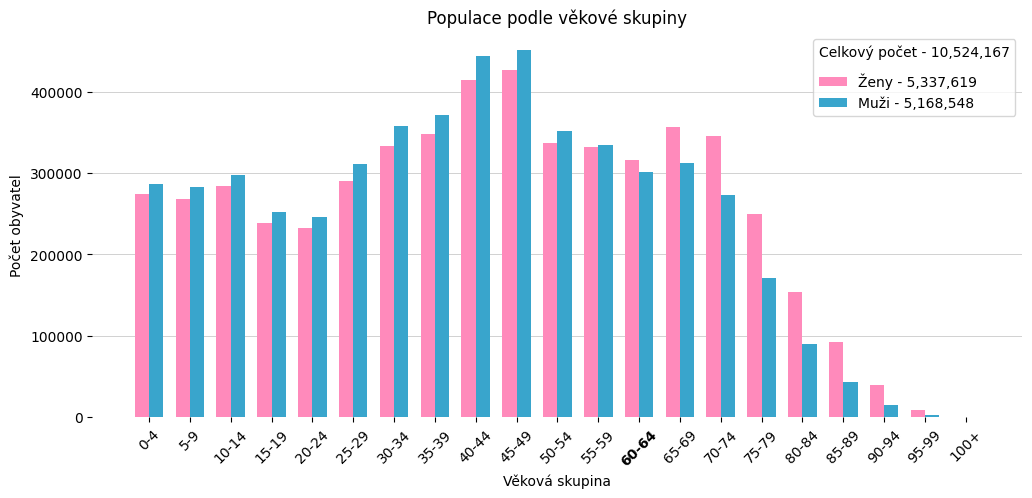

In [10]:
# Věkové kategorie a data
age_groups = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100+']
women_counts = [273743, 267952, 283743, 238290, 231724, 290569, 333508, 347389, 414631, 426913, 337187, 331655, 315642, 356534, 345900, 249134, 153868, 92099, 38676, 7926, 536]
men_counts = [286889, 282072, 297361, 251546, 245339, 310599, 357053, 371700, 443286, 450703, 350923, 334736, 300966, 311547, 272729, 170234, 89505, 43212, 14110, 1927, 111]

# Výpočet celkového počtu obyvatel, žen a mužů
total_population = sum(women_counts) + sum(men_counts)
total_women = sum(women_counts)
total_men = sum(men_counts)

# Šířka sloupců v histogramu
bar_width = 0.35

# Pozice pro skupiny sloupců
index = np.arange(len(age_groups))

# Vytvoření grafu
fig, ax = plt.subplots(figsize=(12, 5))

# Přidání sloupců pro ženy a muže
bar1 = ax.bar(index - bar_width/2, women_counts, bar_width, color='#ff8abb', label='Ženy - 5,337,619')
bar2 = ax.bar(index + bar_width/2, men_counts, bar_width, color='#39a5cc', label='Muži - 5,168,548')

# Přidání popisků, legendy a mřížky
ax.set_xlabel('Věková skupina')
ax.set_ylabel('Počet obyvatel')
ax.set_title('Populace podle věkové skupiny')
ax.set_xticks(index)
ax.set_xticklabels(age_groups, rotation=45)
ax.legend()

# Přidání horizontálních mřížkových čar
ax.grid(axis='y', linestyle='-', color='grey', linewidth=0.5, alpha=0.5)
ax.set_axisbelow(True)  # Nastavení mřížky na pozadí

# Zvýraznění popisku pro skupinu '60-64' tučně
ax.get_xticklabels()[12].set_weight('bold')

# Odstranění ohraničení grafu
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Přidání rozšířené legendy s dodatečným textem
legend = ax.legend(title="Celkový počet - 10,524,167")
legend._legend_box.align = "left"
legend._legend_box.sep = 10  # nastavení mezery mezi položkami

# Zobrazení grafu
plt.show()

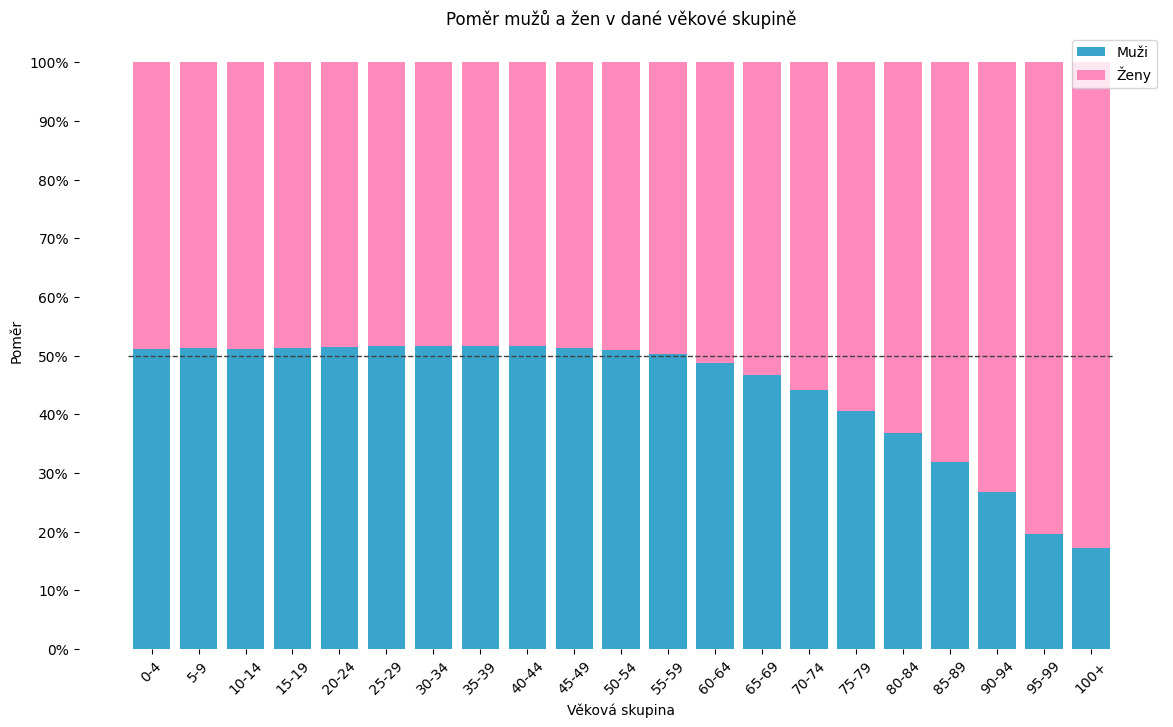

In [54]:
# Data pro zásobníkový sloupcový graf s normalizovanou výškou sloupců
age_groups = [
    '0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', 
    '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100+'
]

# Počty mužů a žen z minulého dotazu
women_counts = [
    273743, 267952, 283743, 238290, 231724, 290569, 333508, 347389, 414631, 426913,
    337187, 331655, 315642, 356534, 345900, 249134, 153868, 92099, 38676, 7926, 536
]
men_counts = [
    286889, 282072, 297361, 251546, 245339, 310599, 357053, 371700, 443286, 450703,
    350923, 334736, 300966, 311547, 272729, 170234, 89505, 43212, 14110, 1927, 111
]

# Výpočet poměrů pro každou skupinu
total_counts = [w + m for w, m in zip(women_counts, men_counts)]
women_ratios = [w / t for w, t in zip(women_counts, total_counts)]
men_ratios = [m / t for m, t in zip(men_counts, total_counts)]

# Vytvoření grafu s normalizovanými sloupci
fig, ax = plt.subplots(figsize=(14, 8))

# Nastavení výšky každého sloupce na 1 pro normalizaci
bar1 = ax.bar(age_groups, men_ratios, label='Muži', color='#39a5cc')
bar2 = ax.bar(age_groups, women_ratios, bottom=men_ratios, label='Ženy', color='#ff8abb')

# Přidání popisků a legendy
ax.set_xlabel('Věková skupina')
ax.set_ylabel('Poměr')
ax.set_title('Poměr mužů a žen v dané věkové skupině')
ax.set_xticks(index)
ax.set_xticklabels(age_groups, rotation=45)
ax.legend()

# Odstranění ohraničení grafu
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Přidání horizontální čáry na úrovni 50%, omezené na rozsah dat
ax.hlines(y=0.5, xmin=-0.5, xmax=len(age_groups)-0.5, colors='#404040', linestyles='--', linewidth=1)

# Nastavení Y osy na procenta
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_yticklabels([f'{int(y*100)}%' for y in np.arange(0, 1.1, 0.1)])

# Zobrazení grafu
plt.show()

/tmp/ipykernel_7075/611449818.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])


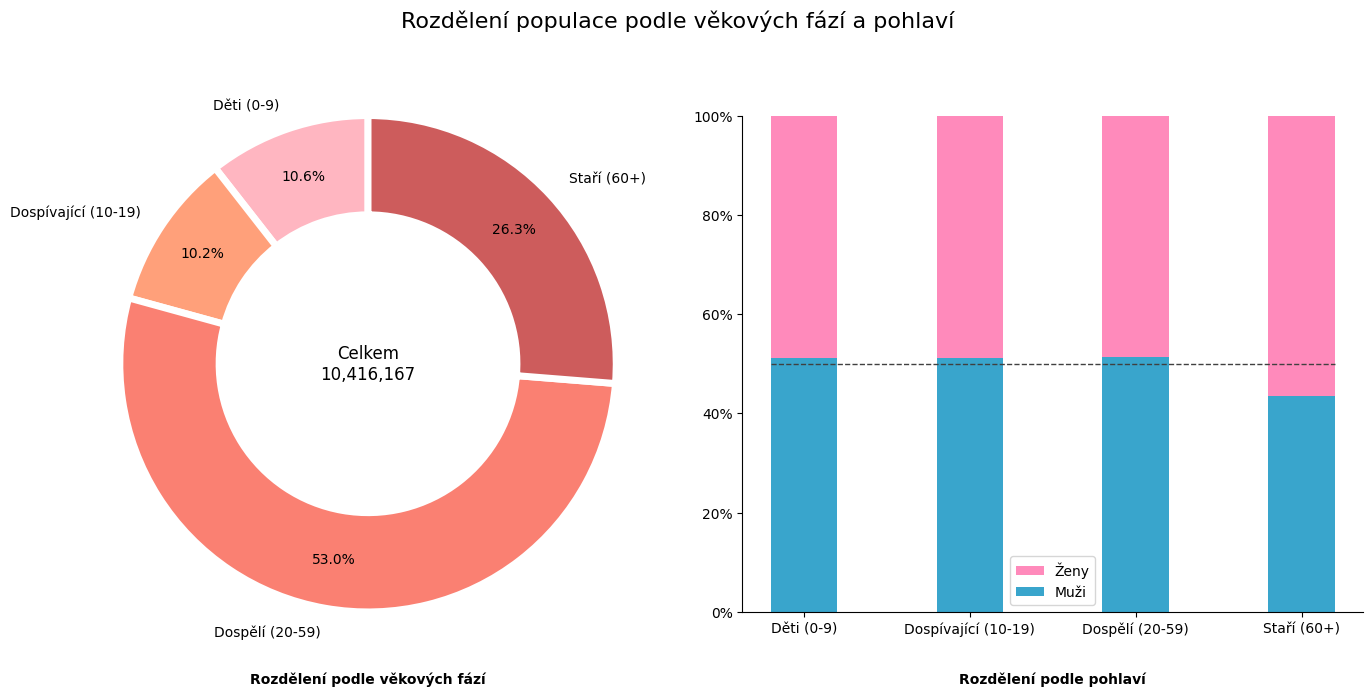

In [8]:
# Data pro oba grafy
group_names = ['Děti (0-9)', 'Dospívající (10-19)', 'Dospělí (20-59)', 'Staří (60+)']
group_sizes = [1110656, 1070940, 5577915, 2764656]  # Suma obyvatel v každé skupině
group_colors = ['#ffb6c1', '#ffa07a', '#fa8072', '#cd5c5c']

# Data pro 100% zásobníkový sloupcový graf
women_counts = [541695, 522033, 2713576, 1560315]
men_counts = [568961, 548907, 2864339, 1204341]
total_counts = [sum(x) for x in zip(women_counts, men_counts)]
women_ratios = [w / t for w, t in zip(women_counts, total_counts)]
men_ratios = [m / t for m, t in zip(men_counts, total_counts)]

# Vytvoření grafu
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# První část: Koláčový graf podle věkových kategorií
axs[0].pie(group_sizes, labels=group_names, colors=group_colors, autopct='%1.1f%%', pctdistance=0.8, startangle=90, wedgeprops=dict(width=0.4, edgecolor='w', linewidth=5))
axs[0].set_xlabel('Rozdělení podle věkových fází', fontdict={'weight': 'bold'})
axs[0].xaxis.set_label_coords(0.5, 0.004)

# Vložení textu do středu grafu
axs[0].text(0, 0, "Celkem\n10,416,167", ha='center', va='center', fontsize=12, color='black')

# Druhá část: 100% zásobníkový sloupcový graf
ind = np.arange(len(group_names))
axs[1].set_box_aspect(0.8)
axs[1].bar(ind, women_ratios, label='Ženy', bottom=men_ratios, color='#ff8abb', width=0.4)
axs[1].bar(ind, men_ratios, label='Muži', color='#39a5cc', width=0.4)
axs[1].set_xticks(ind)
axs[1].set_xticklabels(group_names)
axs[1].set_ylim(0, 1)
axs[1].set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axs[1].set_xlabel('Rozdělení podle pohlaví', fontdict={'weight': 'bold'})
axs[1].xaxis.set_label_coords(0.5, -0.12)
axs[1].legend()

# Odstranění ohraničení grafu
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

# Přidání horizontální čáry na úrovni 50%, omezené na rozsah dat
axs[1].hlines(y=0.5, xmin=-0.2, xmax=len(group_names)-0.8, colors='#404040', linestyles='--', linewidth=1)

# Titulek
fig.suptitle('Rozdělení populace podle věkových fází a pohlaví', fontsize=16)

# Zobrazení grafu
plt.tight_layout()
plt.show()

/tmp/ipykernel_734/2719821813.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(['{:.0f}k'.format(y) for y in axs[0].get_yticks()])
/tmp/ipykernel_734/2719821813.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['{:.0f}k'.format(y) for y in axs[1].get_yticks()])


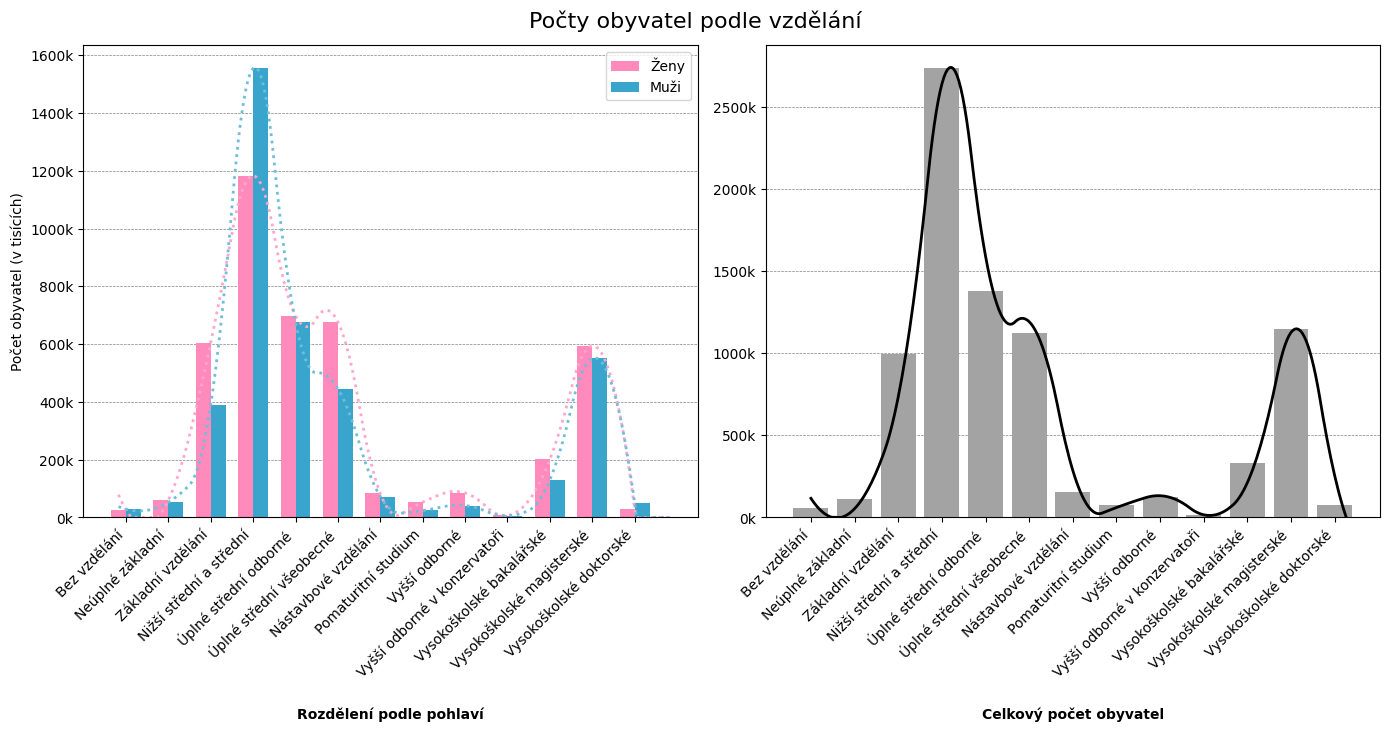

In [68]:
from scipy.interpolate import make_interp_spline

# Definice dat
education_levels = [
    'Bez vzdělání', 'Neúplné základní', 'Základní vzdělání', 
    'Nižší střední a střední', 'Úplné střední odborné', 'Úplné střední všeobecné',
    'Nástavbové vzdělání', 'Pomaturitní studium', 'Vyšší odborné',
    'Vyšší odborné v konzervatoři', 'Vysokoškolské bakalářské',
    'Vysokoškolské magisterské', 'Vysokoškolské doktorské'
]
women_counts = [27440, 59781, 604955, 1182747, 698167, 676678, 83119, 52977, 84747, 6871, 200884, 593633, 28679]
men_counts = [28660, 52684, 390440, 1554236, 676965, 444829, 72232, 24124, 41243, 5727, 130105, 550699, 48407]
total_counts = [w + m for w, m in zip(women_counts, men_counts)]  # Celkový počet pro každou kategorii

# Vytvoření histogramu s popisky v tisících a přidáním křivky symbolizující celkový počet
x = np.arange(len(education_levels))  # Pozice na ose x pro skupiny
x_1 = np.arange(len(education_levels))
x_1 = np.concatenate([x, np.arange(1)])
bar_width = 0.35  # Šířka sloupce

# Převod počtů na tisíce pro lepší čitelnost popisků
women_counts_thousands = [count / 1000 for count in women_counts]
men_counts_thousands = [count / 1000 for count in men_counts]
total_counts_thousands = [count / 1000 for count in total_counts]

# Spline interpolace a úprava křivky
total_counts_adjusted = total_counts_thousands + [0]  # Přidání 0 jako poslední bod
spl = make_interp_spline(np.append(x + bar_width / 2, x.max() + 1.35), total_counts_adjusted, k=2)  # Přidání rozšířeného bodu pro spline
xnew = np.linspace(x.min(), x.max() + 1, 300)  # Rozšíření x osy o jeden bod doprava
y_smooth = spl(xnew)

# Odstranění záporných bodů z křivky
x_filtered = xnew[y_smooth >= 0]
y_filtered = y_smooth[y_smooth >= 0]

# Spline interpolace pro ženy a muže
spl_women = make_interp_spline(x + bar_width / 2, women_counts_thousands, k=2)
spl_men = make_interp_spline(x + bar_width / 2, men_counts_thousands, k=2)

# Filtrace záporných hodnot
y_smooth_women = np.maximum(spl_women(xnew), 0)
y_smooth_men = np.maximum(spl_men(xnew), 0)
y_filtered_women = y_smooth_women[y_smooth_women >= 0]
y_filtered_men = y_smooth_men[y_smooth_men >= 0]

# Vytvoření skupiny grafů, kde vlevo bude histogram a vpravo graf celkových počtů s křivkou
fig, axs = plt.subplots(1, 2, figsize=(14, 8))  # Rozšířené okno pro dva grafy

# První graf: Histogram s rozdělením podle pohlaví a úrovně vzdělání
axs[0].bar(x, women_counts_thousands, width=bar_width, label='Ženy', color='#ff8abb')
axs[0].bar(x + bar_width, men_counts_thousands, width=bar_width, label='Muži', color='#39a5cc')
axs[0].plot(xnew, y_filtered_women, color='#ffa6cb', linestyle='dotted', linewidth=2)
axs[0].plot(xnew, y_filtered_men, color='#6ebedb', linestyle='dotted', linewidth=2)
axs[0].set_ylabel('Počet obyvatel (v tisících)')
axs[0].set_xticks(x + bar_width / 2)
axs[0].set_xticklabels(education_levels, rotation=45, ha='right')
axs[0].set_yticklabels(['{:.0f}k'.format(y) for y in axs[0].get_yticks()])
axs[0].set_axisbelow(True)
axs[0].grid(True, which='major', linestyle='--', linewidth='0.5', color='gray', axis='y')
axs[0].legend()
axs[0].set_xlabel('Rozdělení podle pohlaví', fontdict={'weight': 'bold'})
axs[0].xaxis.set_label_coords(0.5, -0.4)

# Druhý graf: Pouze celkové počty s křivkou
axs[1].bar(x, total_counts_thousands, color='#a3a3a3', label='Celkový počet')
axs[1].plot(x_filtered, y_filtered, label='Celkový počet', color='black', linestyle='-', linewidth=2)
axs[1].set_xticks(x)
axs[1].set_xticklabels(education_levels, rotation=45, ha='right')
axs[1].set_yticklabels(['{:.0f}k'.format(y) for y in axs[1].get_yticks()])
axs[1].set_axisbelow(True)
axs[1].grid(True, which='major', linestyle='--', linewidth='0.5', color='gray', axis='y')
axs[1].set_xlabel('Celkový počet obyvatel', fontdict={'weight': 'bold'})
axs[1].xaxis.set_label_coords(0.5, -0.4)

# Titulek
fig.suptitle('Počty obyvatel podle vzdělání', fontsize=16)

plt.tight_layout()
plt.show()

# Consolas, 'Courier New', monospace